In [36]:
#importing libraries
%matplotlib inline
import pandas
from sklearn.cross_validation import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
#Adding progress bar
!pip install -U tqdm
from tqdm import tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python2.7/dist-packages


In [37]:
#fetching the triplets file and songs metadata file
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

#reading data files for each using pandas and then appending data to data frames with corresponding data frames
song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

print(song_df_1)

#Read song  metadata of songs 
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems with duplicate column in both dataframes as song_id
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")

print(song_df)

                                          user_id             song_id  \
0        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995   
1        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B   
2        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0   
3        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D   
4        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273   
5        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODDNQT12A6D4F5F7E   
6        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODXRTY12AB0180F3B   
7        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOFGUAY12AB017B0A8   
8        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOFRQTD12A81C233C0   
9        b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOHQWYZ12A6D4FA701   
10       b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOIYTOA12A6D4F9A23   
11       b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOIZAZL12A6701C53B   
12       b80344d063b5ccb3212f76538f3d9e43d87dca9e  

In [38]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [39]:
len(song_df)

2000000

In [0]:
#Merge song title and artist_name columns to make a merged column
song_df=song_df[1:10000]
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

In [41]:
len(song_df)

9999

Trimmed songs to 1,000 for faster training, you can always remove this for training on entire data

In [42]:
#Displaying the  most popular songs
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.450045
4677,Undo - Björk,32,0.320032
5104,You're The One - Dwight Yoakam,32,0.320032
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.280028
3655,Secrets - OneRepublic,28,0.280028
4377,The Scientist - Coldplay,27,0.270027
4711,Use Somebody - Kings Of Leon,27,0.270027
3476,Revelry - Kings Of Leon,26,0.260026
1387,Fireflies - Charttraxx Karaoke,24,0.240024
1862,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.230023


In [43]:
#Counting number of individual users
users = song_df['user_id'].unique()
len(users)

365

In [44]:
#splitting the data into training and testing data
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2996  15415fa2745b344bce958967c346f2a89f792f63  SOPTXDZ12A8C13518C   
5317  ffadf9297a99945c0513cd87939d91d8b602936b  SOWOZLK12A8C136B33   
357   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAOBEK12AF72A9021   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2996             2    Un Aro En La Nariz   
5317             1   Doin' The Cockroach   
357              1            Tchaparian   

                                     release     artist_name  year  \
7389                          Battle Studies      John Mayer     0   
9275  Antichrist Superstar (Ecopac Explicit)  Marilyn Manson     0   
2996                           //:Tres.Jeans  Jeans (Mexico)     0   
5317          Baron Von Bullshit R

In [0]:
#creating Class of Recommender

import numpy as np
import pandas

#Class for Popularity based Recommender System model
#works on the listen count principle
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

In [0]:
#creating an instance of popularity
recommender_instance = popularity_recommender_py()
recommender_instance.create(train_data, 'user_id', 'song')

In [47]:
#Using the popularity recommender model to make predictions
user_id = users[1]
recommender_instance.recommend(user_id)

,user_id,song,score,Rank
3182,85c1f87fea955d09b4bec2e36aee110927aedf9a,Sehr kosmisch - Harmonia,39,1.0
4070,85c1f87fea955d09b4bec2e36aee110927aedf9a,Undo - Björk,29,2.0
4435,85c1f87fea955d09b4bec2e36aee110927aedf9a,You're The One - Dwight Yoakam,27,3.0
933,85c1f87fea955d09b4bec2e36aee110927aedf9a,Dog Days Are Over (Radio Edit) - Florence + Th...,25,4.0
3809,85c1f87fea955d09b4bec2e36aee110927aedf9a,The Scientist - Coldplay,24,5.0
1563,85c1f87fea955d09b4bec2e36aee110927aedf9a,Hey_ Soul Sister - Train,20,6.0
4102,85c1f87fea955d09b4bec2e36aee110927aedf9a,Use Somebody - Kings Of Leon,20,7.0
1986,85c1f87fea955d09b4bec2e36aee110927aedf9a,Just Dance - Lady GaGa / Colby O'Donis,19,8.0
2262,85c1f87fea955d09b4bec2e36aee110927aedf9a,Lucky (Album Version) - Jason Mraz & Colbie Ca...,19,9.0
1199,85c1f87fea955d09b4bec2e36aee110927aedf9a,Fireflies - Charttraxx Karaoke,18,10.0


In [0]:

#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in tqdm(range(0,len(all_songs))):
            #Calculate unique listeners (users) of song (item) i
            #print(" Processing Song #"+str(i))
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pandas.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations


## Build a song recommender with better adaptivess using collaborative recommendation.
## It is of 2 types- User Item and Item-Item

We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user. 

In [0]:
#Recall and evaluate function
#Class to calculate precision and recall

import random

class precision_recall_calculator():
    
    def __init__(self, test_data, train_data, pm, is_model):
        self.test_data = test_data
        self.train_data = train_data
        self.user_test_sample = None
        self.model1 = pm
        self.model2 = is_model
        
        self.ism_training_dict = dict()
        self.pm_training_dict = dict()
        self.test_dict = dict()
    
    #Method to return random percentage of values from a list
    def remove_percentage(self, list_a, percentage):
        k = int(len(list_a) * percentage)
        random.seed(0)
        indicies = random.sample(range(len(list_a)), k)
        new_list = [list_a[i] for i in indicies]
    
        return new_list
    
    #Create a test sample of users for use in calculating precision
    #and recall
    def create_user_test_sample(self, percentage):
        #Find users common between training and test set
        users_test_and_training = list(set(self.test_data['user_id'].unique()).intersection(set(self.train_data['user_id'].unique())))
        print("Length of user_test_and_training:%d" % len(users_test_and_training))

        #Take only random user_sample of users for evaluations
        self.users_test_sample = self.remove_percentage(users_test_and_training, percentage)

        print("Length of user sample:%d" % len(self.users_test_sample))
        
    #Method to generate recommendations for users in the user test sample
    def get_test_sample_recommendations(self):
        #For these test_sample users, get top 10 recommendations from training set
        #self.ism_training_dict = {}
        #self.pm_training_dict = {}

        #self.test_dict = {}

        for user_id in self.users_test_sample:
            #Get items for user_id from item similarity model
            print("Getting recommendations for user:%s" % user_id)
            user_sim_items = self.model2.recommend(user_id)
            self.ism_training_dict[user_id] = list(user_sim_items["song"])
    
            #Get items for user_id from popularity model
            user_sim_items = self.model1.recommend(user_id)
            self.pm_training_dict[user_id] = list(user_sim_items["song"])
    
            #Get items for user_id from test_data
            test_data_user = self.test_data[self.test_data['user_id'] == user_id]
            self.test_dict[user_id] = set(test_data_user['song'].unique() )
    
    #Method to calculate the precision and recall measures
    def calculate_precision_recall(self):
        #Create cutoff list for precision and recall calculation
        cutoff_list = list(range(1,11))


        #For each distinct cutoff:
        #    1. For each distinct user, calculate precision and recall.
        #    2. Calculate average precision and recall.

        ism_avg_precision_list = []
        ism_avg_recall_list = []
        pm_avg_precision_list = []
        pm_avg_recall_list = []


        num_users_sample = len(self.users_test_sample)
        for N in cutoff_list:
            ism_sum_precision = 0
            ism_sum_recall = 0
            pm_sum_precision = 0
            pm_sum_recall = 0
            ism_avg_precision = 0
            ism_avg_recall = 0
            pm_avg_precision = 0
            pm_avg_recall = 0

            for user_id in self.users_test_sample:
                ism_hitset = self.test_dict[user_id].intersection(set(self.ism_training_dict[user_id][0:N]))
                pm_hitset = self.test_dict[user_id].intersection(set(self.pm_training_dict[user_id][0:N]))
                testset = self.test_dict[user_id]
        
                pm_sum_precision += float(len(pm_hitset))/float(N)
                pm_sum_recall += float(len(pm_hitset))/float(len(testset))

                ism_sum_precision += float(len(ism_hitset))/float(len(testset))
                ism_sum_recall += float(len(ism_hitset))/float(N)
        
            pm_avg_precision = pm_sum_precision/float(num_users_sample)
            pm_avg_recall = pm_sum_recall/float(num_users_sample)
    
            ism_avg_precision = ism_sum_precision/float(num_users_sample)
            ism_avg_recall = ism_sum_recall/float(num_users_sample)

            ism_avg_precision_list.append(ism_avg_precision)
            ism_avg_recall_list.append(ism_avg_recall)
    
            pm_avg_precision_list.append(pm_avg_precision)
            pm_avg_recall_list.append(pm_avg_recall)
            
        return (pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list)
     

    #A wrapper method to calculate all the evaluation measures
    def calculate_measures(self, percentage):
        #Create a test sample of users
        self.create_user_test_sample(percentage)
        
        #Generate recommendations for the test sample users
        self.get_test_sample_recommendations()
        
        #Calculate precision and recall at different cutoff values
        #for popularity mode (pm) as well as item similarity model (ism)
        
        return self.calculate_precision_recall()
        #return (pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list)    

In [0]:
#Creating an instance of the item-item collaborative recommendation module
is_model = item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

In [51]:

#using training data to make some recommendations
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

  2%|▏         | 77/4480 [00:00<00:05, 766.05it/s]

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
16 Candles - The Crests
Push It - Salt-N-Pepa
Somebody To Love - Justin Bieber
Without Me - Eminem
Speechless - Lady GaGa
My Dad's Gone Crazy - Eminem / Hailie Jade
Just Lose It - Eminem
Missing You - John Waite
Forgive Me - Leona Lewis
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
Ya Nada Queda - Kudai
The Real Slim Shady - Eminem
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4480


100%|██████████| 4480/4480 [00:06<00:00, 739.76it/s]


Non zero values in cooccurence_matrix :2194


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.097867,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067501,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.066479,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.058590,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Forgot About Dre - Dr. Dre / Eminem,0.057265,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,When I Get Where I'm Going - Brad Paisley;Doll...,0.054701,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.054701,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Monster - Lady GaGa,0.052808,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm On A Boat - The Lonely Island / T-Pain,0.052153,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,If I Had You - Adam Lambert,0.052100,10


In [52]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = precision_recall_calculator(test_data, train_data, recommender_instance, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

  2%|▏         | 74/4480 [00:00<00:05, 738.96it/s]

Length of user_test_and_training:322
Length of user sample:16
Getting recommendations for user:55e29789181da8b9c8e9d5f3b624a029492d7616
No. of unique songs for the user: 15
no. of unique songs in the training set: 4480


  0%|          | 0/4480 [00:00<?, ?it/s]

Non zero values in cooccurence_matrix :1547
Getting recommendations for user:07caa920795cd4f20bfeeb0e192a5ddd9566ecdd
No. of unique songs for the user: 41
no. of unique songs in the training set: 4480


  2%|▏         | 74/4480 [00:00<00:05, 739.44it/s]

Non zero values in cooccurence_matrix :9907
Getting recommendations for user:399793ee5842e6f5b0b7f04fa5ec402454e2fe34
No. of unique songs for the user: 5
no. of unique songs in the training set: 4480


  2%|▏         | 73/4480 [00:00<00:06, 723.93it/s]

Non zero values in cooccurence_matrix :1168
Getting recommendations for user:2b6c2f33bc0e887ea7c4411f58106805a1923280
No. of unique songs for the user: 18
no. of unique songs in the training set: 4480


  2%|▏         | 73/4480 [00:00<00:06, 727.14it/s]

Non zero values in cooccurence_matrix :2992
Getting recommendations for user:96e72774fb758108c78d91c110e78133c9ded266
No. of unique songs for the user: 6
no. of unique songs in the training set: 4480


  0%|          | 0/4480 [00:00<?, ?it/s]

Non zero values in cooccurence_matrix :541
Getting recommendations for user:390c2e81bc9cf885608a0891c0a7eb13f1fd3336
No. of unique songs for the user: 61
no. of unique songs in the training set: 4480


  2%|▏         | 73/4480 [00:00<00:06, 722.25it/s]

Non zero values in cooccurence_matrix :21112
Getting recommendations for user:3fef4e71c70ae99ef8a4da00e431f9cdb2b1b729
No. of unique songs for the user: 19
no. of unique songs in the training set: 4480


  2%|▏         | 75/4480 [00:00<00:05, 744.67it/s]

Non zero values in cooccurence_matrix :746
Getting recommendations for user:5aa89364746d7f350d35a403da8f397bd9d32b41
No. of unique songs for the user: 14
no. of unique songs in the training set: 4480


  2%|▏         | 76/4480 [00:00<00:05, 753.06it/s]

Non zero values in cooccurence_matrix :265
Getting recommendations for user:2418d6837aada8911991cc748bc70a9a479f0cb4
No. of unique songs for the user: 5
no. of unique songs in the training set: 4480


  2%|▏         | 72/4480 [00:00<00:06, 715.29it/s]

Non zero values in cooccurence_matrix :304
Getting recommendations for user:4c84359a164b161496d05282707cecbd50adbfc4
No. of unique songs for the user: 3
no. of unique songs in the training set: 4480


  2%|▏         | 73/4480 [00:00<00:06, 722.08it/s]

Non zero values in cooccurence_matrix :162
Getting recommendations for user:1fdf267d8e81db0bb69093460fdab8254e69a2de
No. of unique songs for the user: 4
no. of unique songs in the training set: 4480


  2%|▏         | 69/4480 [00:00<00:06, 681.87it/s]

Non zero values in cooccurence_matrix :422
Getting recommendations for user:edc8b7b1fd592a3b69c3d823a742e1a064abec95
No. of unique songs for the user: 19
no. of unique songs in the training set: 4480


  2%|▏         | 74/4480 [00:00<00:05, 735.68it/s]

Non zero values in cooccurence_matrix :3376
Getting recommendations for user:9d6f0ead607ac2a6c2460e4d14fb439a146b7dec
No. of unique songs for the user: 8
no. of unique songs in the training set: 4480


  2%|▏         | 73/4480 [00:00<00:06, 728.69it/s]

Non zero values in cooccurence_matrix :4018
Getting recommendations for user:f28f980d8842ebfaa31e8fb3939aace4a43a18ec
No. of unique songs for the user: 20
no. of unique songs in the training set: 4480


  2%|▏         | 69/4480 [00:00<00:06, 683.30it/s]

Non zero values in cooccurence_matrix :1490
Getting recommendations for user:62f2f9b881dc320d745a90c0c10528d18e10deb1
No. of unique songs for the user: 9
no. of unique songs in the training set: 4480


  2%|▏         | 73/4480 [00:00<00:06, 728.95it/s]

Non zero values in cooccurence_matrix :2148
Getting recommendations for user:1645b689f873529ab85e3b72742be44813e82bd3
No. of unique songs for the user: 14
no. of unique songs in the training set: 4480


100%|██████████| 4480/4480 [00:06<00:00, 718.44it/s]

Non zero values in cooccurence_matrix :4537
102.059797049


In [0]:
#plotting precision plot
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


In [0]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


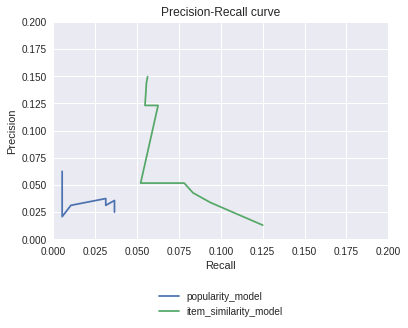

In [55]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")
